In [1]:
import pandas as pd
import numpy as np
import fileinput
from IPython.display import display
import ipywidgets as widgets
import PyPDF2
import io
import re

# Read File

In [42]:
extracted_text = ""

# def handle_pdf_upload(change):
#     print ('Start')
#     global extracted_text
    
#     uploaded_file = list(change.new.values())[0]
#     content = uploaded_file['content']
    
#     reader = PyPDF2.PdfFileReader(io.BytesIO(content))
#     text = ''
#     for page in reader.pages:
#         text += page.extract_text()

#     # Further processing with the extracted text
#     extracted_text = text
#     print(text)
#     print('PDF submitted successfully!')

# file_selector = widgets.FileUpload(accept='.xlsx', multiple = False)
# file_selector.observe(handle_pdf_upload, names='value')

def handle_file_upload(change):
    print('Start')
    global extracted_text

    uploaded_file = list(change.new.values())[0]
    content = uploaded_file['content']
    file_type = uploaded_file['metadata']['name'].split('.')[-1]  # Extract file type from name

    text = ""
    if file_type == 'xlsx':
        data = pd.read_excel(io.BytesIO(content), sheet_name=None)
        for sheet,df in data.items():
            print (sheet)
            
        # Only keep sheets that match the format "CONDENSED CONSOLIDATED STATEM_#"
        data = {sheet: df for sheet, df in data.items() if re.match(r'CONDENSED CONSOLIDATED*', sheet)}
        for sheet, df in data.items():
            text += f"\n\n--- {sheet} ---\n\n"
            text += df.to_string(index = False)
    elif file_type == 'csv':
        data = pd.read_csv(io.StringIO(content.decode('utf-8')))  # Decoding needed for CSV file
        text = data.to_string(index = False)

    # Further processing with the extracted text
    extracted_text = text
    print(text)
    print(f'{file_type.upper()} file submitted successfully!')

file_selector = widgets.FileUpload(accept='.xlsx, .csv', multiple = False)
file_selector.observe(handle_file_upload, names='value')

display(file_selector)

FileUpload(value={}, accept='.xlsx, .csv', description='Upload')

Start
Cover
CONDENSED CONSOLIDATED BALANCE 
CONDENSED CONSOLIDATED BALANC_2
CONDENSED CONSOLIDATED STATEMEN
CONDENSED CONSOLIDATED STATEM_2
CONDENSED CONSOLIDATED STATEM_3
CONDENSED CONSOLIDATED STATEM_4
Organization and Basis of Prese
Summary of Significant Accounti
Revenue
Fair Value Measurements
Balance Sheet Components
Leases
Debt
Commitments and Contingencies
Common Stock
Stock-based Compensation
Net Loss per Share Attributable
Income Taxes
Business Combinations
Segment and Geographic Informat
Subsequent Events
Summary of Significant Accoun_2
Revenue (Tables)
Fair Value Measurements (Tables
Balance Sheet Components (Table
Leases (Tables)
Debt (Tables)
Commitments and Contingencies (
Common Stock (Tables)
Stock-based Compensation (Table
Net Loss per Share Attributab_2
Business Combinations (Tables)
Segment and Geographic Inform_2
Revenue - Disaggregation of Rev
Revenue - Narratives (Details)
Revenue - Deferred Contract Acq
Revenue - Remaining Performance
Fair Value Measurements - S

In [43]:
extracted_text

"\n\n--- CONDENSED CONSOLIDATED BALANCE  ---\n\nCONDENSED CONSOLIDATED BALANCE SHEETS - USD ($) $ in Thousands Mar. 31, 2023 Dec. 31, 2022\n                                               Current assets:             \xa0             \xa0\n                                     Cash and cash equivalents        256363        204178\n                                 Available-for-sale securities       1459229       1445759\n                                      Accounts receivable, net        179749        148544\n                                               Contract assets          8023          8292\n                                    Restricted cash short-term         10505         10555\n                     Prepaid expenses and other current assets         40531         70556\n                                          Total current assets       1954400       1887884\n                                   Property and equipment, net        298188        286600\n                          

# LLM usage

In [3]:
import openai

# Load API key from a separate file
with open("openai.txt", "r") as file:
    api_key = file.read().strip()

openai.api_key = api_key

In [51]:
import textwrap

generated_text = ""

def generate_text_with_openai(extracted_text):
    chunk_size=12000 # adjust based on the used model
    chunks = textwrap.wrap(extracted_text, chunk_size)

    generated_texts = []

    for chunk in chunks:

#         # Set the prompt for the OpenAI model
#         prompt = f"You are a financial analysis with 20 years of experience. You are set to analyze, \
#                     summarize, identify and highlight information from conference call transcript. \
#                     Here is the transscript: {extracted_text}"

        # Set the desired number of tokens for the generated text
        max_tokens = 12000  # Adjust the value as per your requirement

        # Generate text using the OpenAI model
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo-16k", # change model here depends on documentation
#             prompt=prompt,
            messages=[
                # If use for summary conference call transcript
#                 {
#                     "role": "system",
#                     "content": "You are a financial analysis with 20 years of experience. \
#                                 User will give you transcript, you will analyze, summarize, identify and highlight \
#                                 information from conference call transcript. \
#                                 You will firstly assess if this call is positive, neutral or negative for the company.\
#                                 The other information is in bullet point"
#                 },
                
#               If use for financial reading
                {
                    "role": "system",
                    "content": "You are a financial analysis with 20 years of experience. \
                                User will give you financial reports, you will analyze, summarize, identify and highlight \
                                information from that given report. \
                                For the output, information is in bullet point. Sample output is like this:\
                                - Cash and cash equivalents increased|decreased|remained stable $123 $234"
                },
                {
                    "role": "user",
                    "content": chunk
                }
            ],
            max_tokens=max_tokens,
            n=1,
            stop=None,
            temperature=0.7
        )

        # Extract the generated text from the OpenAI response
        generated_text = response.choices[0].message.content.strip()
        
        generated_texts.append(generated_text)
        
    # Combine all the generated text chunks into one string
    full_generated_text = " ".join(generated_texts)

    return full_generated_text

generated_text = generate_text_with_openai(extracted_text)

In [52]:
generated_text

"- Cash and cash equivalents increased from $204,178 to $256,363.\n- Available-for-sale securities increased from $1,445,759 to $1,459,229.\n- Accounts receivable, net increased from $148,544 to $179,749.\n- Contract assets decreased from $8,292 to $8,023.\n- Prepaid expenses and other current assets decreased from $70,556 to $40,531.\n- Total current assets increased from $1,887,884 to $1,954,400.\n- Property and equipment, net increased from $286,600 to $298,188.\n- Goodwill remained stable at $148,047.\n- Acquired intangible assets, net decreased from $32,483 to $27,596.\n- Operating lease right-of-use assets decreased from $132,360 to $130,908.\n- Deferred contract acquisition costs, noncurrent increased from $93,145 to $98,427.\n- Restricted cash increased from $471 to $1,564.\n- Other noncurrent assets increased from $6,918 to $8,434.\n- Total assets increased from $2,587,908 to $2,667,564.\n- Accounts payable increased from $35,607 to $54,563.\n- Accrued expenses and other curre

# Convert to DF

In [2]:
# Avoid rerun model, costing money:
generated_text = "- Cash and cash equivalents increased from $204,178 to $256,363.\n- Available-for-sale securities increased from $1,445,759 to $1,459,229.\n- Accounts receivable, net increased from $148,544 to $179,749.\n- Contract assets decreased from $8,292 to $8,023.\n- Prepaid expenses and other current assets decreased from $70,556 to $40,531.\n- Total current assets increased from $1,887,884 to $1,954,400.\n- Property and equipment, net increased from $286,600 to $298,188.\n- Goodwill remained stable at $148,047.\n- Acquired intangible assets, net decreased from $32,483 to $27,596.\n- Operating lease right-of-use assets decreased from $132,360 to $130,908.\n- Deferred contract acquisition costs, noncurrent increased from $93,145 to $98,427.\n- Restricted cash increased from $471 to $1,564.\n- Other noncurrent assets increased from $6,918 to $8,434.\n- Total assets increased from $2,587,908 to $2,667,564.\n- Accounts payable increased from $35,607 to $54,563.\n- Accrued expenses and other current liabilities increased from $66,425 to $69,374.\n- Accrued compensation increased from $42,014 to $45,669.\n- Operating lease liabilities increased from $33,275 to $34,796.\n- Deferred revenue increased from $218,647 to $238,795.\n- Total current liabilities increased from $397,870 to $444,505.\n- Convertible senior notes, net increased from $1,436,192 to $1,437,355.\n- Operating lease liabilities, noncurrent increased from $107,624 to $108,804.\n- Deferred revenue, noncurrent increased from $11,732 to $13,465.\n- Other noncurrent liabilities increased from $10,526 to $10,849.\n- Total liabilities increased from $1,963,944 to $2,014,978.\n- Additional paid-in capital increased from $1,475,423 to $1,536,367.\n- Accumulated deficit increased from -$839,891 to -$877,973.\n- Accumulated other comprehensive loss decreased from -$11,896 to -$6,138.\n- Total stockholders' equity increased from $623,964 to $652,586.\n- Common stock, value, issued increased from 286 to 289 shares for Class A common stock.\n- Common stock, value, issued decreased from 42 to 41 shares for Class B common stock.\n- Revenue increased from $212,167 to $290,175.\n- Cost of revenue increased from $47,051 to $70,432.\n- Gross profit increased from $165,116 to $219,743.\n- Sales and marketing expenses increased from $100,057 to $137,001.\n- Research and development expenses increased from $67,054 to $81,539.\n- General and administrative expenses increased from $38,029 to $48,475.\n- Loss from operations decreased from -$40,024 to -$47,272.\n- Interest income increased from $1,061 to $13,487.\n- Interest expense decreased from -$1,557 to -$2,126.\n- Other income (expense), net decreased from -$487 to -$857.\n- Total non-operating income (expense), net increased from -$983 to $10,504.\n- Loss before income taxes decreased from -$41,007 to -$36,768.\n- Provision for income taxes increased from $374 to $1,314.\n- Net loss decreased from -$41,381 to -$38,082.\n- Net loss per share attributable to common stockholders, basic remained stable at -$0.12.\n- Net loss per share attributable to common stockholders, diluted remained stable at -$0.12.\n- Weighted-average shares used in computing net loss per share attributable to common stockholders, basic increased from 323,334 to 330,389.\n- Weighted-average shares used in computing net loss per share attributable to common stockholders, diluted increased from 323,334 to 330,389.\n- Other comprehensive income (loss) increased from -$10,100 to $5,758.\n- Comprehensive loss decreased from -$51,481 to -$32,324. - Issuance of common stock in connection with acquisition: 19,000 shares issued\n- Issuance of restricted stock in connection with acquisition: 52,000 shares issued\n- Issuance of common stock upon exercise of stock options: 65,000 shares issued\n- Vesting of shares issued upon early exercise of stock options: 23,000 shares vested\n- Issuance of common stock related to settlement of restricted stock units (RSUs): 410,000 shares issued\n- Tax withholding on RSU settlement: 6,000 shares withheld\n- Conversion of Class B to Class A common stock: 1,861,000 shares converted\n- Settlement of common stock in connection with convertible senior notes: 299,000 shares settled\n- Stock-based compensation: $35,181\n- Net loss: $41,381\n- Other comprehensive income (loss): -$10,100\n- Ending balance of common stock at Mar. 31, 2022: 515,477 shares\n- Ending balance of additional paid-in capital at Mar. 31, 2022: $1,215,790\n- Ending balance of retained earnings at Mar. 31, 2022: -$687,891\n- Ending balance of accumulated other comprehensive loss at Mar. 31, 2022: -$12,745\n- Beginning balance of common stock at Dec. 31, 2022: 623,964 shares\n- Beginning balance of additional paid-in capital at Dec. 31, 2022: $1,475,423\n- Beginning balance of retained earnings at Dec. 31, 2022: -$839,891\n- Beginning balance of accumulated other comprehensive loss at Dec. 31, 2022: -$11,896\n- Increase in stockholders' equity from issuance of common stock upon exercise of stock options: 806,000 shares issued - Issuance of common stock upon exercise of stock options: 3305 shares\n- Vesting of shares issued upon early exercise of stock options: 590 shares\n- Issuance of common stock related to settlement of restricted stock units (RSUs): 0 shares\n- Tax withholding on RSU settlement: -2058 shares\n- Conversion of Class B to Class A common stock: 2024000 shares\n- Stock-based compensation: $59,109\n- Net loss: -$38,082\n- Other comprehensive income (loss): $5,758\n- Ending balance of shares at Mar. 31, 2023: 289,372,222 shares\n- Ending balance at Mar. 31, 2023: $652,586\n- Net loss for the quarter: -$38,082\n- Depreciation and amortization expense: $31,509\n- Non-cash operating lease costs: $11,061\n- Amortization of deferred contract acquisition costs: $14,109\n- Stock-based compensation expense: $57,401\n- Amortization of debt issuance costs: $1,163\n- Net accretion of discounts and amortization of premiums on available-for-sale securities: -$8,228\n- Deferred income taxes: -$120\n- Provision for bad debt: $1,576\n- Changes in operating assets and liabilities, net of effect of acquisitions:\n  - Accounts receivable, net: -$32,781\n  - Contract assets: $269\n  - Deferred contract acquisition costs: -$19,391\n  - Prepaid expenses and other current assets: -$8,934\n  - Other noncurrent assets: -$811\n  - Accounts payable: $11,634\n  - Accrued expenses and other current liabilities: $650\n  - Operating lease liabilities: -$6,908\n  - Deferred revenue: $21,881\n  - Other noncurrent liabilities: $430\n- Net cash provided by (used in) operating activities: $36,414\n- Purchases of property and equipment: -$17,541\n- Capitalized internal-use software: -$4,970\n- Cash paid for acquisitions, net of cash acquired: $0\n- Purchases of available-for-sale securities: -$476,206\n- Sales of available-for-sale securities: $20,248\n- Maturities of available-for-sale securities: $493,988\n- Other investing activities: $48\n- Net cash provided by (used in) investing activities: $15,567\n- Repayments of convertible senior notes: $0\n- Proceeds from the exercise of stock options: $3,305\n- Proceeds from the early exercise of stock options: $0\n- Repurchases of unvested common stock: $0\n- Payment of tax withholding obligation on RSU settlement: -$2,058\n- Net cash provided by (used in) financing activities: $1,247\n- Net increase (decrease) in cash, cash equivalents, and restricted cash: $53,228\n- Cash, cash equivalents, and restricted cash, beginning of period: $215,204\n- Cash, cash equivalents, and restricted cash, end of period: $268,432 - Cash paid for interest: $1\n- Cash paid for income taxes, net of refunds: $1,260 (paid) and $874 (net of refunds)\n- Cash paid for operating lease liabilities: $7,265 (paid) and $8,291 (net)\n- Stock-based compensation capitalized for software development: $1,640 (capitalized)\n- Accounts payable and accrued expenses related to property and equipment additions: $13,276 (accounts payable) and $16,922 (accrued expenses)\n- Vesting of early exercised stock options: $590\n- Indemnity holdback consideration associated with business combinations: $0 (initial) and $1,275 (associated with business combinations)\n- Issuance of common stock related to an acquisition: $0 (initial) and $1,957 (related to an acquisition)\n- Operating lease right-of-use assets obtained in exchange for operating lease liabilities: $8,071 (obtained) and $15,966 (in exchange for operating lease liabilities)"

In [12]:
def parse_generated_text(text):
    # Initialize an empty list to hold all matches.
    results = []
    
    # Define patterns to match different cases.
    patterns = [
        (r'- (.*?) (increased|decreased|remained stable) from (-?\$[\d,]+) to (-?\$[\d,]+)', 4),  # default pattern
        (r'- (Common stock, value, issued) (decreased|increased) from (\d+) to (\d+) shares for (Class A|Class B) common stock.', 5)  # special case for Common stock
#         (r'- (Net loss) (increased| decreased| remained stable) from (-\$[\d,]+) to (-\$[\d,]+)', 4)  # special case for Net loss
    ]

    # Apply each pattern in turn.
    for pattern, length in patterns:
        matches = re.findall(pattern, text)
#         print (matches)
#         print ("------------------")

        # Append all matches from this pattern to the results list.
        if matches[0][0] == 'Common stock, value, issued':
            print (matches[0][0])
                
        results.extend([(match[0], match[1], match[2], match[3]) if len(match) == 4 else \
                        (match[0] + ' ' + match[4], match[1], match[2], match[3]) for match in matches])

    # Create a DataFrame from the list of tuples.
    df = pd.DataFrame(results, columns=['Metric', 'Status', 'Last Time', 'Now'])

    # Display the DataFrame.
    data = df
    
    return data

data = parse_generated_text(generated_text)
data

Common stock, value, issued


,Metric,Status,Last Time,Now
0,Cash and cash equivalents,increased,"$204,178","$256,363"
1,Available-for-sale securities,increased,"$1,445,759","$1,459,229"
2,"Accounts receivable, net",increased,"$148,544","$179,749"
3,Contract assets,decreased,"$8,292","$8,023"
4,Prepaid expenses and other current assets,decreased,"$70,556","$40,531"
5,Total current assets,increased,"$1,887,884","$1,954,400"
6,"Property and equipment, net",increased,"$286,600","$298,188"
7,"Acquired intangible assets, net",decreased,"$32,483","$27,596"
8,Operating lease right-of-use assets,decreased,"$132,360","$130,908"
9,"Deferred contract acquisition costs, noncurrent",increased,"$93,145","$98,427"


In [13]:
# # Define the new order of rows.
# new_order = list(range(23)) + [36] + [37] + list(range(24, 36))

# # Reindex the DataFrame.
# data = data.reindex(new_order)

# # Reset index of DataFrame.
# data = data.reset_index(drop=True)

# # Display the DataFrame.
# data

# Quick Analysis

We will provide a quick overview of the company performance based on these categories:

    Financial Health: Use the Debt-to-Equity ratio, Current Ratio and Operating Cash Flow. To keep things simple, Operating Cash Flow is approximated as 'Cash and cash equivalents'. Interest Coverage Ratio will also be looked at.

    Future Growth: Use the growth rates of 'Revenue' compared to 'Cost of Revenue' and 'Sales and Marketing Expenses'. Earnings Growth will also be looked at.

    Sustainable Value: Use Return on Equity (ROE) and Return on Asset (ROA). Be aware that a company in the dataframe can have a negative accumulated profit (i.e., a deficit), so the ROE might also be negative.

    Current Ratio: This ratio measures a company's ability to pay short-term and long-term obligations. It's calculated by dividing total current assets by total current liabilities. >=10% is Good.

    Debt Ratio: This ratio compares a company's total debt to its total assets, which gives stakeholders an indication of the company's leverage. It's calculated by dividing total liabilities by total assets. <= 30% is Good.

    Return on Equity: This is the amount of net income returned as a percentage of shareholders equity, calculated by dividing net loss by total stockholders' equity. >= 10% is Good

    Revenue Growth Rate: This rate measures the rate at which a company's sales are increasing. It's calculated by subtracting the revenue of the 'Last Time' from the 'Now' and then dividing by the 'Last Time' revenue. >= 20% is Good

    Interest Coverage Ratio: This ratio measures a company's ability to meet its interest payments on its debt. It's calculated by dividing earnings before interest and taxes by interest expense. However, since the company is running at a loss, and we have 'Loss from operations', this might not give a meaningful value. >= 3 is Good

    Earnings Growth: This is the rate at which the company's earnings (EPS) are growing. However, the dataset does not provide EPS. Another substitute could be the growth in 'Net loss', which would not be exactly earnings growth but could give an indication of profitability change. >= 10% is Good

    Return on Assets: This is an indicator of how profitable a company is relative to its total assets, calculated by dividing net loss by total assets. If profitable, >=10% is good.

In [20]:
import matplotlib.pyplot as plt
from math import pi

# Convert money columns to float
df = data
# Convert money columns to float
for col in ['Last Time', 'Now']:
    df[col] = df[col].replace('[\$,]', '', regex=True).astype(float)

# Metrics Calculation
df['Current Ratio'] = df.loc[df['Metric'] == 'Total current assets', 'Now'].values[0] / \
                      df.loc[df['Metric'] == 'Total current liabilities', 'Now'].values[0]

df['Debt Ratio'] = df.loc[df['Metric'] == 'Total liabilities', 'Now'].values[0] / \
                   df.loc[df['Metric'] == 'Total assets', 'Now'].values[0]

df['Return on Equity'] = df.loc[df['Metric'] == 'Net loss', 'Now'].values[0] / \
                         df.loc[df['Metric'] == "Total stockholders' equity", 'Now'].values[0]

df['Revenue Growth Rate'] = (df.loc[df['Metric'] == 'Revenue', 'Now'].values[0] - \
                             df.loc[df['Metric'] == 'Revenue', 'Last Time'].values[0]) / \
                             df.loc[df['Metric'] == 'Revenue', 'Last Time'].values[0]

# If 'Interest expense' is negative, we calculate 'Interest Coverage Ratio' as 'Loss from operations' divided by the absolute value of 'Interest expense'
if df.loc[df['Metric'] == 'Interest expense', 'Now'].values[0] < 0:
    df['Interest Coverage Ratio'] = df.loc[df['Metric'] == 'Loss from operations', 'Now'].values[0] / \
                                    abs(df.loc[df['Metric'] == 'Interest expense', 'Now'].values[0])
else:
    df['Interest Coverage Ratio'] = np.nan

df['Earnings Growth'] = (df.loc[df['Metric'] == 'Net loss', 'Now'].values[0] - \
                         df.loc[df['Metric'] == 'Net loss', 'Last Time'].values[0]) / \
                         abs(df.loc[df['Metric'] == 'Net loss', 'Last Time'].values[0])

df['Return on Assets'] = df.loc[df['Metric'] == 'Net loss', 'Now'].values[0] / \
                          df.loc[df['Metric'] == 'Total assets', 'Now'].values[0]

df

,Metric,Status,Last Time,Now,Current Ratio,Debt Ratio,Return on Equity,Revenue Growth Rate,Interest Coverage Ratio,Earnings Growth,Return on Assets
0,Cash and cash equivalents,increased,204178.0,256363.0,4.396801,0.755363,-0.058356,0.367673,-22.235183,0.079723,-0.014276
1,Available-for-sale securities,increased,1445759.0,1459229.0,4.396801,0.755363,-0.058356,0.367673,-22.235183,0.079723,-0.014276
2,"Accounts receivable, net",increased,148544.0,179749.0,4.396801,0.755363,-0.058356,0.367673,-22.235183,0.079723,-0.014276
3,Contract assets,decreased,8292.0,8023.0,4.396801,0.755363,-0.058356,0.367673,-22.235183,0.079723,-0.014276
4,Prepaid expenses and other current assets,decreased,70556.0,40531.0,4.396801,0.755363,-0.058356,0.367673,-22.235183,0.079723,-0.014276
5,Total current assets,increased,1887884.0,1954400.0,4.396801,0.755363,-0.058356,0.367673,-22.235183,0.079723,-0.014276
6,"Property and equipment, net",increased,286600.0,298188.0,4.396801,0.755363,-0.058356,0.367673,-22.235183,0.079723,-0.014276
7,"Acquired intangible assets, net",decreased,32483.0,27596.0,4.396801,0.755363,-0.058356,0.367673,-22.235183,0.079723,-0.014276
8,Operating lease right-of-use assets,decreased,132360.0,130908.0,4.396801,0.755363,-0.058356,0.367673,-22.235183,0.079723,-0.014276
9,"Deferred contract acquisition costs, noncurrent",increased,93145.0,98427.0,4.396801,0.755363,-0.058356,0.367673,-22.235183,0.079723,-0.014276


In [38]:
# Data Preparation for Radar Chart
metrics = ['Current Ratio', 'Debt Ratio', 'Earnings Growth', 'Revenue Growth Rate',
           'Interest Coverage Ratio','Return on Equity', 'Return on Assets']

# We will create a new dataframe to store our calculated metrics
metrics_df = pd.DataFrame(index=metrics)

# Get the calculated values for each metric
metrics_df['Value'] = [df[metric].values[0] for metric in metrics]

# Normalization
metrics_df['Normalized Value'] = (metrics_df['Value'] - metrics_df['Value'].min()) / \
                                 (metrics_df['Value'].max() - metrics_df['Value'].min())

# Number of Variables
num_vars = len(metrics)

# Compute angle each axis in the plot will be
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

# Repeat the first value to close the circular graph
values = metrics_df['Normalized Value'].tolist() + metrics_df['Normalized Value'].tolist()[:1]

if df['Return on Equity'][0] < 0:
    values[5] = 0.0
if df['Return on Assets'][0] < 0:  
    values[6] = 0.0
values

[1.0,
 0.8632682299012402,
 0.837898734977906,
 0.8487109243042195,
 0.0,
 0.0,
 0.0,
 1.0]

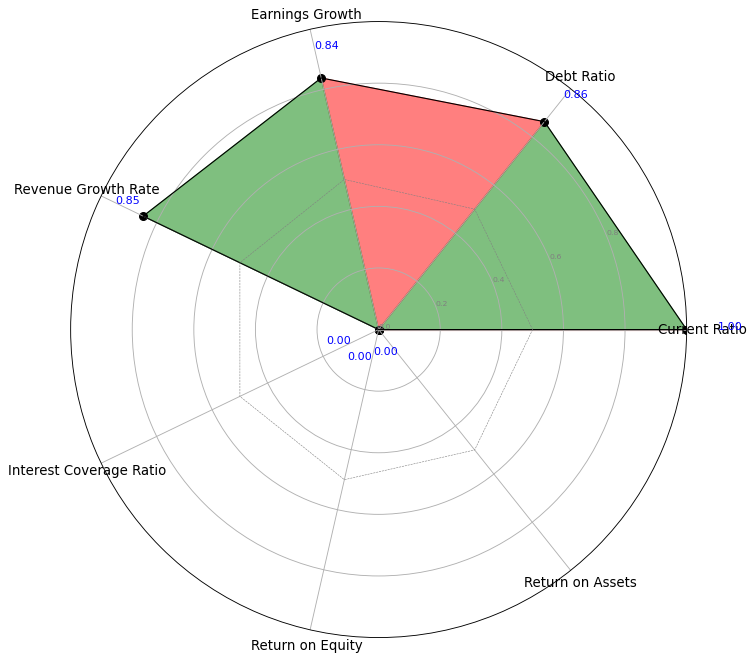

In [49]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=80, subplot_kw=dict(polar=True))

# Define the thresholds
thresholds = [1, 0.3, 0.1, 0.1, 0.8, 0.1, 0.1]

# Draw filled polygons
for i in range(num_vars):
    if (metrics[i] == "Current Ratio" and values[i] >= thresholds[i]) or \
       (metrics[i] == "Debt Ratio" and values[i] <= thresholds[i]) or \
       (metrics[i] != "Current Ratio" and metrics[i] != "Debt Ratio" and values[i] >= thresholds[i]):
        color = 'green'
    else:
        color = 'red'
    ax.fill(angles[i:i+2] + angles[i:i+2][::-1],
            values[i:i+2] + [0, 0],
            color=color, alpha=0.5)

# # Draw filled polygons
# for i in range(num_vars):
#     if metrics[i] == "Debt Ratio":
#         color = 'green' if values[i] <= values[i+1] else 'red'
#     else:
#         color = 'green' if values[i] >= values[i+1] else 'red'
#     ax.fill(angles[i:i+2] + angles[i:i+2][::-1],
#             values[i:i+2] + [0, 0],
#             color=color, alpha=0.5)

# Draw outline and points
ax.plot(angles, values, color="black", linewidth=1)
ax.scatter(angles, values, color="black", s=50)

# Draw labels and y-ticks
plt.xticks(angles[:-1], metrics, color='black', size=12)
plt.yticks(np.arange(0, 1, 0.2), color='grey', size=7)
plt.ylim(0, 1)

# Draw y=0.5 line
ax.plot(angles, [0.5] * len(angles), linestyle='dashed', color='grey', linewidth=0.5)

# Annotate values
for angle, value, label in zip(angles, values, metrics):
    if angle > pi:
        alignment = {'horizontalalignment': 'right', 'verticalalignment': 'baseline'}
    else:
        alignment = {'horizontalalignment': 'left', 'verticalalignment': 'baseline'}
    ax.text(angle, value + 0.1, f'{value:.2f}', size=10, color='blue', **alignment)

plt.show()